In [61]:
import numpy as np
import pandas as pd
import plotly.express as px
import itertools
import scipy.stats as ss
from scipy import stats
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kstest
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [31]:
def evaluation(y_true, y_pred):

   cm = confusion_matrix(y_true, y_pred)
   tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

   fig = px.imshow(cm_df.iloc[[1,0],[1,0]],
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Positive', 'Predicted Negative'],
                y=['Actual Positive', 'Actual Negative'],
                color_continuous_scale=px.colors.sequential.Blues, text_auto=True)

   fig.update_traces(showscale=True) 
   fig.update_layout(title='Confusion Matrix')
   fig.show()

   sensitivity = tp / (tp + fn)
   specificity = tn / (tn + fp)
   precision = tp / (tp + fp)
   mcc = matthews_corrcoef(y_true, y_pred)

   print('Sensitivity (Recall): ' + str(round(sensitivity,2)) + "\n"+'Specificity: '+ str(round(specificity,2))+ "\n"+'Precision: '+ str(round(precision,2)) + "\n"+'MCC: ' + str(round(mcc,2)))

In [46]:
def calcualte_specificity(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

In [53]:
def run_cv(model, balancing_algorithm = None):
    cv = StratifiedKFold(n_splits=10)
    precision_scores = []
    recall_scores = []
    specificity_scores = []
    mcc_scores = []
    for train, val in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train], X_train.iloc[val]
        y_train_fold, y_val_fold = y_train.iloc[train], y_train.iloc[val]

        if balancing_algorithm != None:
            X_train_fold_balanced, y_train_fold = balancing_algorithm.fit_resample(X_train_fold, y_train_fold)
        else:
            X_train_fold_balanced = X_train_fold

        mms = MinMaxScaler()
        mms.fit(X_train_fold)
        X_train_fold_scaled = mms.transform(X_train_fold_balanced)
        X_val_fold_scaled = mms.transform(X_val_fold)

        model.fit(X_train_fold_scaled, y_train_fold)
        y_pred_val_fold = model.predict(X_val_fold_scaled)
        precision_scores.append(precision_score(y_val_fold, y_pred_val_fold))
        recall_scores.append(recall_score(y_val_fold, y_pred_val_fold))
        specificity_scores.append(calcualte_specificity(y_val_fold, y_pred_val_fold))
        mcc_scores.append(matthews_corrcoef(y_val_fold, y_pred_val_fold))

    average_precision_score = np.mean(precision_scores)
    average_recall_score = np.mean(recall_scores)
    average_specificity_score = np.mean(specificity_scores)
    average_mcc_score = np.mean(mcc_scores)

    # print(f"Average precision: {average_precision_score:.2f} \nAverage recall: {average_recall_score:.2f} \nAverage specificity: {average_specificity_score:.2f} \nAverage mcc: {average_mcc_score:.2f}")
    return average_precision_score, average_recall_score, average_specificity_score, average_mcc_score

In [69]:
# Data Insertion
df = pd.read_csv(r'../data/processed/processed_data.csv')
del df["Unnamed: 0"]

In [70]:
X = df.drop(columns=['Churn'])
y = df['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Training features shape: (5634, 28)
Testing features shape: (1409, 28)


In [44]:
majority_class = y_train.value_counts().idxmax()
X_test['target'] = majority_class
y_true = y_test
y_pred = X_test['target']

evaluation(y_true, y_pred)

Sensitivity (Recall): 0.0
Specificity: 1.0
Precision: nan
MCC: 0.0


In [54]:
alg = dict()

my_lr = LogisticRegression()
my_dt = tree.DecisionTreeClassifier()
my_svm = svm.LinearSVC()

my_smote = SMOTE(sampling_strategy = 1)
my_ros = RandomOverSampler(sampling_strategy = 1)

alg["LR_unbalanced"] = run_cv(my_lr)
alg["LR_SMOTE"] = run_cv(my_lr, my_smote)
alg["LR_ROS"] = run_cv(my_lr, my_ros)

alg["DT_unbalanced"] = run_cv(my_dt)
alg["DT_SMOTE"] = run_cv(my_dt, my_smote)
alg["DT_ROS"] = run_cv(my_dt, my_ros)

alg["SVM_unbalanced"] = run_cv(my_svm)
alg["SVM_SMOTE"] = run_cv(my_svm, my_smote)
alg["SVM_ROS"] = run_cv(my_svm, my_ros)

In [55]:
alg

{'LR_unbalanced': (0.6638894341596502,
  0.5400643932523128,
  0.9011268261451605,
  0.473762153366952),
 'LR_SMOTE': (0.5937951018397423,
  0.6456421186286959,
  0.8410889936557824,
  0.4744920366636284),
 'LR_ROS': (0.5146730326414566,
  0.793578813713042,
  0.7308887724812292,
  0.4710130342808706),
 'DT_unbalanced': (0.48988138347542154,
  0.5016597134046799,
  0.8123939235201677,
  0.3118055599438949),
 'DT_SMOTE': (0.48429243696857344,
  0.5313032831489208,
  0.7964780862580757,
  0.31878769983758753),
 'DT_ROS': (0.4960044623260904,
  0.49902049700707424,
  0.8172190210115826,
  0.31594260740408175),
 'SVM_unbalanced': (0.6667624262525772,
  0.5373707600217668,
  0.9030586112566208,
  0.4744436199897013),
 'SVM_SMOTE': (0.6003750990280035,
  0.6469798657718121,
  0.8449449973808276,
  0.48087536276188675),
 'SVM_ROS': (0.51049192510648,
  0.8029974605477962,
  0.7226913450905069,
  0.47089222122042457)}

In [56]:
def find_best_combination(metric_dict, target):
    best_score = 0
    best_key = None
    for key, value in metric_dict.items():
        score = value[target]
        if score > best_score:
            best_score = score
            best_key = key
    return best_key

print(find_best_combination(alg, 1))

SVM_ROS


In [58]:
param_grid = {'linearsvc__C': [0.1, 1, 10, 100, 1000]} 

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = RandomOverSampler(sampling_strategy=1, random_state=42)

svc = svm.LinearSVC()

pipeline = make_pipeline(mms, sm, svc)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'linearsvc__C': 0.1}
Best recall score:  0.7969435878831852


In [59]:
param_grid = {'linearsvc__C': [0.1, 1, 10, 100, 1000]} 

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = SMOTE(sampling_strategy=1, random_state=42)

svc = svm.LinearSVC()

pipeline = make_pipeline(mms, sm, svc)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'linearsvc__C': 10}
Best recall score:  0.784831307817885


Best hyperparameters:  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 5}
Best recall score:  0.8520179575548703


[Text(0.5, 0.8333333333333334, 'Contract_Month-to-month <= 0.007\nentropy = 1.0\nsamples = 8294\nvalue = [4147, 4147]'),
 Text(0.25, 0.5, 'InternetService_Fiber_optic <= 0.026\nentropy = 0.573\nsamples = 2723\nvalue = [2353, 370]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.338\nsamples = 1786\nvalue = [1674, 112]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.849\nsamples = 937\nvalue = [679, 258]'),
 Text(0.75, 0.5, 'InternetService_Fiber_optic <= 0.013\nentropy = 0.907\nsamples = 5571\nvalue = [1794, 3777]'),
 Text(0.625, 0.16666666666666666, 'entropy = 1.0\nsamples = 2084\nvalue = [1022, 1062]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.763\nsamples = 3487\nvalue = [772, 2715]')]

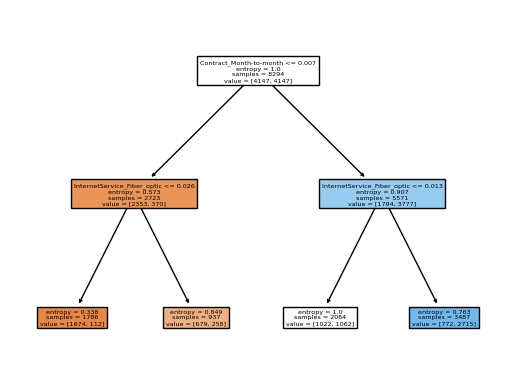

In [62]:
from sklearn.tree import plot_tree

# Define the pipeline and the parameter grid
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
    'decisiontreeclassifier__criterion': ["gini", "entropy"]
}

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = SMOTE(sampling_strategy=1, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)

pipeline = make_pipeline(mms, sm, decision_tree)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, params, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# access the best estimator from GridSearchCV
best_tree = grid_search.best_estimator_.named_steps['decisiontreeclassifier']

# plot the decision tree
plot_tree(best_tree, feature_names=X_train.columns, filled=True)

Best hyperparameters:  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 5}
Best recall score:  0.8420914202793396


[Text(0.5, 0.8333333333333334, 'Contract_Month-to-month <= 0.5\nentropy = 1.0\nsamples = 8294\nvalue = [4147, 4147]'),
 Text(0.25, 0.5, 'InternetService_Fiber_optic <= 0.5\nentropy = 0.633\nsamples = 2799\nvalue = [2353, 446]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.412\nsamples = 1825\nvalue = [1674, 151]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.885\nsamples = 974\nvalue = [679, 295]'),
 Text(0.75, 0.5, 'InternetService_Fiber_optic <= 0.5\nentropy = 0.911\nsamples = 5495\nvalue = [1794, 3701]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.999\nsamples = 2107\nvalue = [1022, 1085]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.774\nsamples = 3388\nvalue = [772, 2616]')]

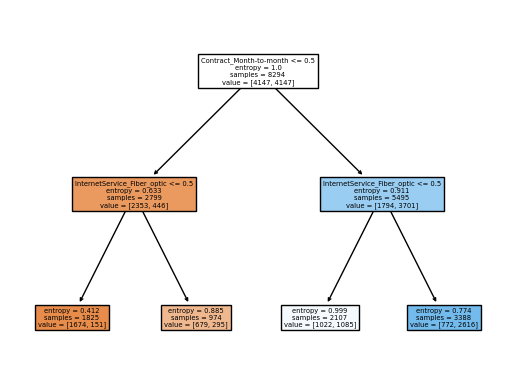

In [63]:
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
    'decisiontreeclassifier__criterion': ["gini", "entropy"]
}

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = RandomOverSampler(sampling_strategy=1, random_state=42)
decision_tree = tree.DecisionTreeClassifier(random_state=42)

pipeline = make_pipeline(mms, sm, decision_tree)
grid_search = GridSearchCV(pipeline, params, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# access the best estimator from GridSearchCV
best_tree = grid_search.best_estimator_.named_steps['decisiontreeclassifier']

# plot the decision tree
plot_tree(best_tree, feature_names=X_train.columns, filled=True)

In [64]:
parameters = {'logisticregression__penalty': ['l1','l2'],
              'logisticregression__C': [0.1, 0.4, 0.8, 1, 2, 5]
              }

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = RandomOverSampler(sampling_strategy=1, random_state=42)
lr = LogisticRegression(random_state=42)

pipeline = make_pipeline(mms, sm, lr)
grid_search = GridSearchCV(pipeline, parameters, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'logisticregression__C': 0.8, 'logisticregression__penalty': 'l2'}
Best recall score:  0.7895474333393796


In [65]:
parameters = {'logisticregression__penalty': ['l1','l2'],
              'logisticregression__C': [0.1, 0.4, 0.8, 1, 2, 5]
              }

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = SMOTE(sampling_strategy=1, random_state=42)
lr = LogisticRegression(random_state=42)

pipeline = make_pipeline(mms, sm, lr)
grid_search = GridSearchCV(pipeline, parameters, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Best recall score:  0.7808089969163795


In [66]:
hp_algs = dict()

my_dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, min_samples_leaf = 5)

my_smote = SMOTE(sampling_strategy = 1)
my_ros = RandomOverSampler(sampling_strategy = 1)

hp_algs["LR_unbalanced"] = run_cv(my_lr)
hp_algs["LR_SMOTE"] = run_cv(LogisticRegression(C = 0.1, penalty = 'l2'), my_smote)
hp_algs["LR_ROS"] = run_cv(LogisticRegression(C = 0.8, penalty = 'l2'), my_ros)

hp_algs["DT_unbalanced"] = run_cv(my_dt)
hp_algs["DT_SMOTE"] = run_cv(my_dt, my_smote)
hp_algs["DT_ROS"] = run_cv(my_dt, my_ros)

hp_algs["SVM_unbalanced"] = run_cv(my_svm)
hp_algs["SVM_SMOTE"] = run_cv(svm.LinearSVC(C = 10), my_smote)
hp_algs["SVM_ROS"] = run_cv(svm.LinearSVC(C = 0.1), my_ros)

In [67]:
print(find_best_combination(hp_algs, 1))

DT_ROS


In [68]:
hp_algs

{'LR_unbalanced': (0.6638894341596502,
  0.5400643932523128,
  0.9011268261451605,
  0.473762153366952),
 'LR_SMOTE': (0.5802082327555158,
  0.6732042445129693,
  0.824684826261568,
  0.47641358977231824),
 'LR_ROS': (0.5150227423738036,
  0.794925630328315,
  0.7306472265875094,
  0.4720141525102143),
 'DT_unbalanced': (0.5473467959205636,
  0.6254670778160711,
  0.8138373784995052,
  0.4221824380966105),
 'DT_SMOTE': (0.43807724900406547,
  0.8640758207872302,
  0.5905279087363948,
  0.40754234531358235),
 'DT_ROS': (0.4322961192712026,
  0.8702793397424269,
  0.5840620452825795,
  0.4054379499887487),
 'SVM_unbalanced': (0.6667624262525772,
  0.5373707600217668,
  0.9030586112566208,
  0.4744436199897013),
 'SVM_SMOTE': (0.6034902107615269,
  0.6496508253219663,
  0.8463890343984634,
  0.48501628659576734),
 'SVM_ROS': (0.5104624770496721,
  0.7989524759658988,
  0.7238915080612304,
  0.4687048432473788)}

In [71]:
mms = MinMaxScaler() # Normalization
numerical_features = ['Tenure', 'MonthlyCharges']
# fit the scaler on the training data and transform it
X_train[numerical_features] = mms.fit_transform(X_train[numerical_features])

# transform the test data using the same scaler
X_test[numerical_features] = mms.transform(X_test[numerical_features])

In [72]:
ros = RandomOverSampler(sampling_strategy = 1)
X_res_over, y_res_over = ros.fit_resample(X_train, y_train)

In [73]:
svc_final = svm.LinearSVC(C = 0.1).fit(X_res_over, y_res_over)
y_pred_class = svc_final.predict(X_test)

evaluation(y_test, y_pred_class)

Sensitivity (Recall): 0.79
Specificity: 0.73
Precision: 0.52
MCC: 0.47
